# Aprendizaje Automatico - TP 1 : Prueba de sanidad

A modo de validar que no todos los modelos funcionen como deben, no demoren una cantidad extraordinaria de tiempo ni invertamos tiempo entrendando modelos que no tienen para nada buena performance, realizamos cross-validation sobre un subconjunto del dataset de entrenamiento

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from scripts.util import *
from scripts.builders import *

In [2]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 0.924000s

Loading Test Set
Done in 0.222000s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


In [3]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb', 'multinomial_nb', 'knn', 'svm']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)

In [4]:
scores, cv_times = evaluate_and_meassure(train_set.sample(10000), pipelines, 'sanity', cv=10, n_jobs=5)

Loading previous scores
Done in 0.004000s
Loading previous cv_times
Done in 0.000000s

Loaded from previous run 10-Fold CV for pipeline simple_features__dt(1/258)
CV scores mean: 0.896100 std: 0.008029

Loaded from previous run 10-Fold CV for pipeline simple_features__random_forest(2/258)
CV scores mean: 0.927699 std: 0.009349

Loaded from previous run 10-Fold CV for pipeline simple_features__bernoulli_nb(3/258)
CV scores mean: 0.831000 std: 0.011183

Loaded from previous run 10-Fold CV for pipeline simple_features__multinomial_nb(4/258)
CV scores mean: 0.546900 std: 0.014646

Loaded from previous run 10-Fold CV for pipeline simple_features__knn(5/258)
CV scores mean: 0.624102 std: 0.012976

Loaded from previous run 10-Fold CV for pipeline simple_features__svm(6/258)
CV scores mean: 0.637401 std: 0.010737

Loaded from previous run 10-Fold CV for pipeline simple_features__body_tfidf__dt(7/258)
CV scores mean: 0.957899 std: 0.007193

Loaded from previous run 10-Fold CV for pipeline simpl

### TODO: Visualizaciones (usando DataFrame?) de los resultados, tanto puntajes de CV como runtimes

In [5]:
len(scores)

258

In [6]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]

    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [7]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

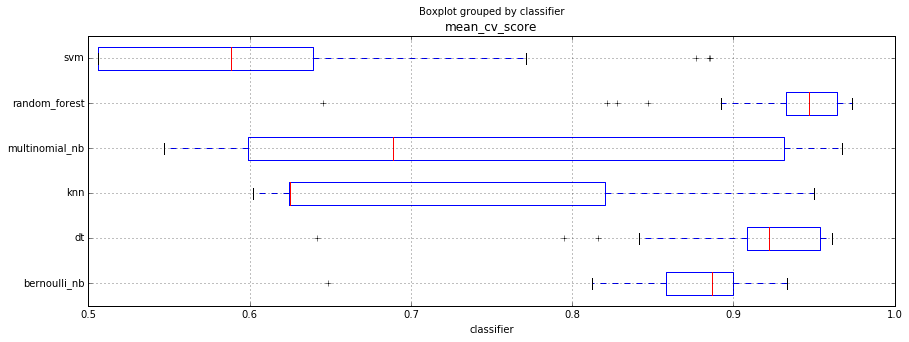

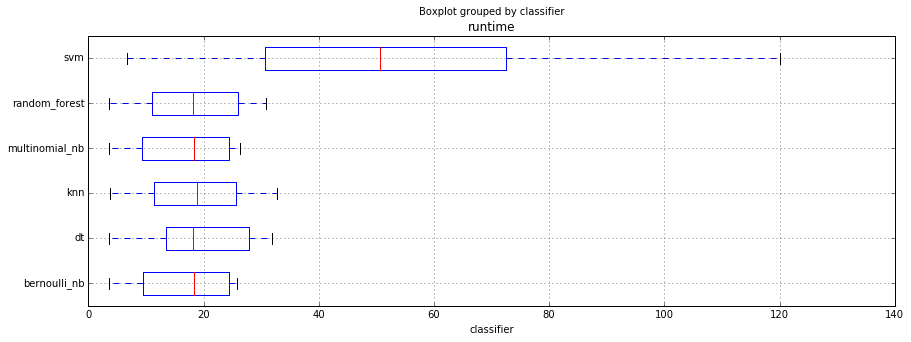

In [8]:
summary_df.boxplot(column=['mean_cv_score'], by='classifier', vert=False)
summary_df.boxplot(column=['runtime'], by='classifier', vert=False)